In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

path = '../../preprocessed_data&EDA/dataset/internet_service_churn.csv'
df_tree = pd.read_csv(path, encoding='utf-8')
df_tree.head()

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,15,1,0,11.95,25,0.14,0,8.4,2.3,0,0
1,18,0,0,8.22,0,NaN,0,0.0,0.0,0,1
2,23,1,0,8.91,16,0.00,0,13.7,0.9,0,1
3,27,0,0,6.87,21,NaN,1,0.0,0.0,0,1
4,34,0,0,6.39,0,NaN,0,0.0,0.0,0,1


In [63]:
df_tree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72274 entries, 0 to 72273
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           72274 non-null  int64  
 1   is_tv_subscriber             72274 non-null  int64  
 2   is_movie_package_subscriber  72274 non-null  int64  
 3   subscription_age             72274 non-null  float64
 4   bill_avg                     72274 non-null  int64  
 5   reamining_contract           50702 non-null  float64
 6   service_failure_count        72274 non-null  int64  
 7   download_avg                 71893 non-null  float64
 8   upload_avg                   71893 non-null  float64
 9   download_over_limit          72274 non-null  int64  
 10  churn                        72274 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 6.1 MB


- `id`: userID
- `is_tv_subscriber`: TV 구독 여부 [1:구독, 0:미구독]
- `is_movie_package_subscriber`: 영화 패키지(시네마) 구독 여부 [1:구독, 0:미구독]
- `subscription_age`: 서비스 이용 기간(년 단위), 고객이 서비스를 이용한 총 연수
- `bill_avg`: 최근 3개월 평균 청구 금액 (단위: $)
- `remaining_contract`: 남은 계약 기간(년 단위), **null이면 계약 없음**. 계약 중 고객은 중도 해지 시 위약금 발생
- `service_failure_count`: 최근 3개월 동안 고객센터에 신고한 서비스 장애 건수 / 서비스 품질 관련 지표
- `download_avg`: 최근 3개월 평균 다운로드 사용량(GB) / 인터넷 사용량 지표
- `upload_avg`: 최근 3개월 평균 업로 사용량(GB) / 인터넷 업로드 사용량
- `download_over_limit`: 지난 9개월 동안 다운로드 한도 초과 횟수, 한도 초과 시 추가 요금 발생
- `churn`: 이탈 여부(**target**) [1:서비스 해지, 0:서비스 유지]

In [64]:
cols = [
    'is_tv_subscriber',
    'is_movie_package_subscriber',
    'subscription_age',
    'reamining_contract',
    'service_failure_count',
    'download_avg',
    'upload_avg',
    'download_over_limit'
]

df_tree[cols].describe()

,is_tv_subscriber,is_movie_package_subscriber,subscription_age,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit
count,72274.000000,72274.000000,72274.000000,50702.000000,72274.000000,71893.000000,71893.000000,72274.000000
mean,0.815259,0.334629,2.450051,0.716039,0.274234,43.689911,4.192076,0.207613
std,0.388090,0.471864,2.034990,0.697102,0.816621,63.405963,9.818896,0.997123
min,0.000000,0.000000,-0.020000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.930000,0.000000,0.000000,6.700000,0.500000,0.000000
50%,1.000000,0.000000,1.980000,0.570000,0.000000,27.800000,2.100000,0.000000
75%,1.000000,1.000000,3.300000,1.310000,0.000000,60.500000,4.800000,0.000000
max,1.000000,1.000000,12.800000,2.920000,19.000000,4415.200000,453.300000,7.000000


In [65]:
df_tree.isna().sum()

id                                 0
is_tv_subscriber                   0
is_movie_package_subscriber        0
subscription_age                   0
bill_avg                           0
reamining_contract             21572
service_failure_count              0
download_avg                     381
upload_avg                       381
download_over_limit                0
churn                              0
dtype: int64

# ☀ Preprocessing - tree

### reamining_contract
- 남은 계약기간이 NaN -> 무약정 사용자
- 0 -> 계약 만료
- 0 초과 -> 계약기간 남음

In [66]:
# id 컬럼 삭제
df_tree = df_tree.drop(columns=['id'])

In [67]:
import numpy as np

conditions = [
    df_tree['reamining_contract'].isnull(),
    df_tree['reamining_contract'] == 0,
    df_tree['reamining_contract'] > 0
]

choices = ['no_contract', 'expired', 'active']

df_tree['contract_type'] = np.select(conditions, choices, default='unknown')


In [68]:
# 라벨링
contract_dict = {
    'no_contract': 0,  # 계약 없음
    'expired': 1,      # 계약 만료
    'active': 2,       # 활성 상태
}

df_tree['contract_type'] = df_tree['contract_type'].map(contract_dict)

In [69]:
df_tree = df_tree.drop(columns=['reamining_contract'])

### dwonload_avg & upload_avg
download_avg가 NaN이면 upload_avg도 NaN

In [70]:
df_tree = df_tree.dropna(subset=['download_avg'])

In [71]:
df_tree['upload_avg'].isna().sum()

0

### subscription_age

In [72]:
# subscription_age가 음수값인 row 확인
df_tree[df_tree['subscription_age'] < 0]

,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,service_failure_count,download_avg,upload_avg,download_over_limit,churn,contract_type
69320,0,0,-0.02,0,0,32.6,1.3,0,1,2


In [73]:
# 음수값 제거
df_tree = df_tree[df_tree['subscription_age'] >= 0]

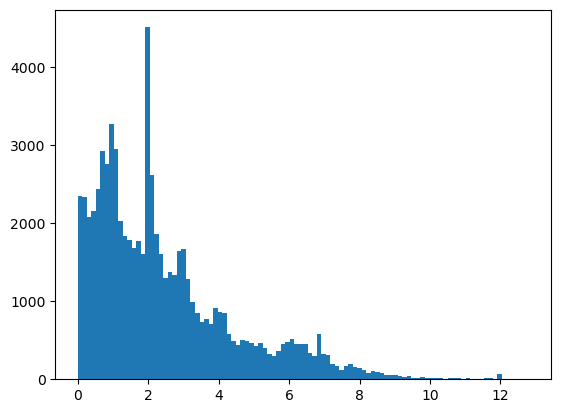

In [74]:
# 구독 연수 분포 확인
import matplotlib.pyplot as plt
plt.hist(df_tree['subscription_age'], bins=100)
plt.show()

In [75]:
# 구독 연수 나누기 subscription_age_group 컬럼 생성
import numpy as np

bins = [0, 1, 3, 5, np.inf]
# 초기, 중기(약정), 장기(재계약), 충성고객
labels = ['0~1years', '1~3years', '3~5years', 'greater than 5years']

df_tree['subscription_age_group'] = pd.cut(
    df_tree['subscription_age'],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True
)

In [76]:
# 라벨링
dict = {'0~1years':0, '1~3years':1, '3~5years':2, 'greater than 5years':3}
df_tree['subscription_age_group'] = df_tree['subscription_age_group'].map(dict).astype(int)

In [77]:
# subscription_age 드랍
df_tree = df_tree.drop(columns=['subscription_age'])

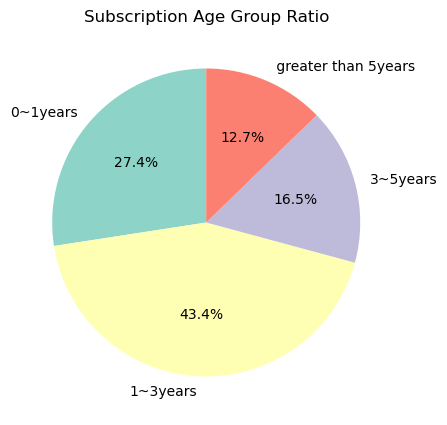

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

mapping = {'0~1years': 0, '1~3years': 1, '3~5years': 2, 'greater than 5years': 3}
labels = ['0~1years', '1~3years', '3~5years', ' greater than 5years']

counts = df_tree['subscription_age_group'].replace(mapping).value_counts().sort_index()

plt.figure(figsize=(5,5))
plt.pie(
    counts,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette('Set3')
)
plt.title('Subscription Age Group Ratio')
plt.show()

- 남은 약정 기간이 1~3년인 고객이 43.4%로 가장 많다. -> domain정보: 기본 계약 기간이 1년, 2년, 3년으로 많이 나뉘고 3년을 가장 많이 계약함
- 0~1년 27.4%
- 3~5년 16.5%
- 5년 초과 12.7%


In [79]:
df_tree['subscription_age_group'].value_counts()

subscription_age_group
1    31175
0    19725
2    11836
3     9156
Name: count, dtype: int64

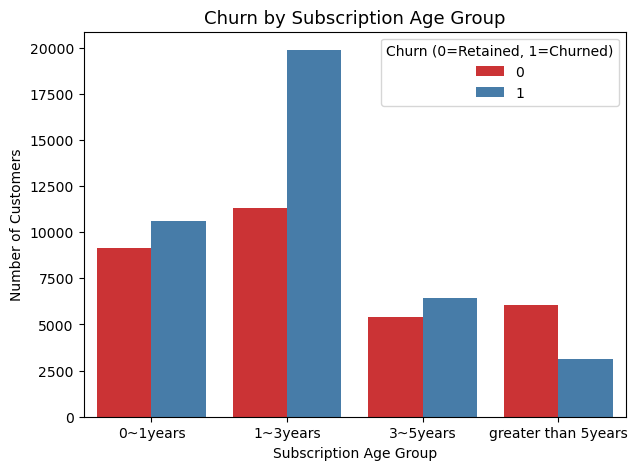

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

mapping = {'0~1years': 0, '1~3years': 1, '3~5years': 2, 'greater than 5years': 3}
order = [0, 1, 2, 3]
labels = ['0~1years', '1~3years', '3~5years', 'greater than 5years']

plt.figure(figsize=(7,5))
sns.countplot(
    x=df_tree['subscription_age_group'].replace(mapping),
    hue=df_tree['churn'],
    order=order,
    palette='Set1'
)

plt.title('Churn by Subscription Age Group', fontsize=13)
plt.xlabel('Subscription Age Group')
plt.ylabel('Number of Customers')
plt.legend(title='Churn (0=Retained, 1=Churned)')
plt.xticks(ticks=order, labels=labels)

plt.show()

- 약정 기간이 1~3년일 때 이탈 고객이 가장 매우 많음. 왜?
- 5년 초과는 유지 고객이 더 많음.

## subscription_label 생성

In [81]:
# TV와 영화 구독 확인
df_tree.groupby(['is_tv_subscriber', 'is_movie_package_subscriber']).size()

is_tv_subscriber  is_movie_package_subscriber
0                 0                              13281
                  1                                  2
1                 0                              34594
                  1                              24015
dtype: int64

In [82]:
# 구독 상태 통합 컬럼 생성
df_tree['subscription_label'] = df_tree.apply(
    lambda row: (
        'both' if row['is_tv_subscriber'] == 1 and row['is_movie_package_subscriber'] == 1 else
        'tv' if row['is_tv_subscriber'] == 1 else
        'movie' if row['is_movie_package_subscriber'] == 1 else
        'none'
    ),
    axis=1
)

df_tree.drop(['is_tv_subscriber', 'is_movie_package_subscriber'], axis=1, inplace=True)

In [83]:
# 라벨링
subscription_label_dict = {
    'none': 0,   # 구독 없음
    'tv': 1,     # TV만 구독
    'movie': 2,  # 영화만 구독
    'both': 3    # 둘 다 구독
}

df_tree['subscription_label'] = df_tree['subscription_label'].map(subscription_label_dict)

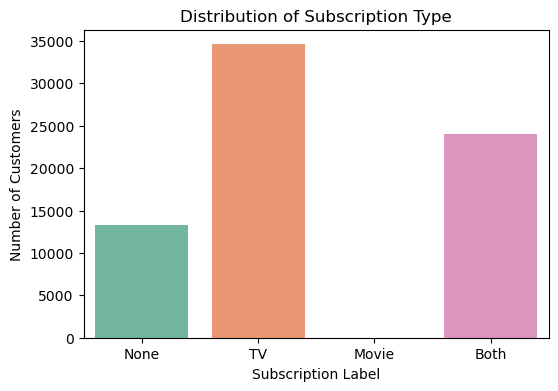

In [84]:
label_names = {0: 'None', 1: 'TV', 2: 'Movie', 3: 'Both'}

plt.figure(figsize=(6,4))
sns.countplot(
    data=df_tree,
    x='subscription_label',
    hue='subscription_label',
    palette='Set2',
    legend=False
)
plt.title('Distribution of Subscription Type')
plt.xlabel('Subscription Label')
plt.ylabel('Number of Customers')

plt.xticks(ticks=[0,1,2,3], labels=[label_names[i] for i in range(4)])
plt.show()

In [85]:
df_tree['subscription_label'].value_counts()

subscription_label
1    34594
3    24015
0    13281
2        2
Name: count, dtype: int64

- TV만 구독한 고객이 34954명으로 가장 많다.
- 다음으로 Both 24015명, None 13281명
- Movie만 구독한 고객은 겨우 2명임.

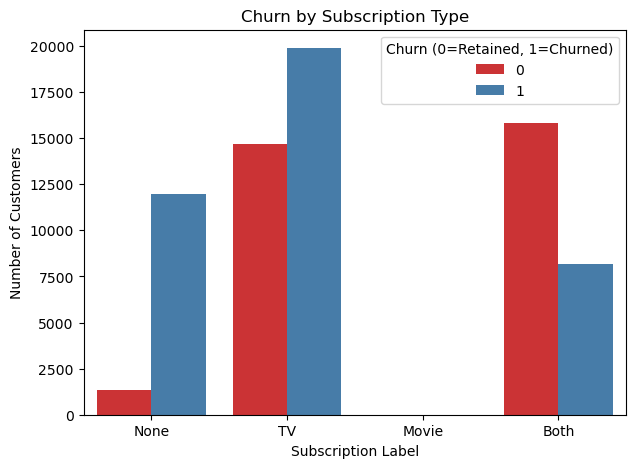

In [86]:
plt.figure(figsize=(7,5))
sns.countplot(
    data=df_tree,
    x='subscription_label',
    hue='churn',
    palette='Set1'
)
plt.title('Churn by Subscription Type')
plt.xlabel('Subscription Label')
plt.ylabel('Number of Customers')
plt.legend(title='Churn (0=Retained, 1=Churned)')
plt.xticks(ticks=[0,1,2,3], labels=[label_names[i] for i in range(4)])
plt.show()

- 아무 것도 구독하지 않은 고객(None)은 유지에 비해 이탈 고객이 훨 많음
- TV만 구독한 고객(TV)는 이탈 고객이 더 많고 유지 고객과 적당히 차이남
- 둘 다 구독한 고객(Both)는 유지 고객이 이탈 고객보다 반 정도 더 많음

In [87]:
df_tree.to_csv("tree_model_preprocessed.csv", index=False, encoding='utf-8-sig')

# from google.colab import files
# files.download("tree_model_preprocessed.csv")

In [88]:
df_tree.shape

(71892, 9)

# ☀ EDA

| 변수                            | 주요 관찰 포인트                                                        |
| ----------------------------- | ---------------------------------------------------------------- |
| **bill_avg**                  | 평균 19, 최댓값 406 → 일부 **극단적인 이상치 존재 가능성 높음**                       |
| **service_failure_count**     | 대부분 0, 최대 19 → **심하게 편향된 분포**                                    |
| **download_avg / upload_avg** | 평균보다 최대값이 100배 이상 → **Outlier** 확인 필요                    |
| **download_over_limit**       | 평균 0.2, 최대 7 → 이산형 변수지만 0~7까지 → **사용제한 초과 횟수로 볼 수 있음**, 분포 확인 필요 |
| **churn**                     | 평균 0.55 → **이탈률 55%** 정도 (비교적 균형 잡힌 편)                           |
| **contract_type**             | 평균 1.17, 범위 0~2 → 세 그룹(무약정, 만료, 활성) 분포 비교 필요                     |
| **subscription_age_group**    | 평균 1.14, 범위 0~3 → 약정기간별 이탈 차이 확인 필요                              |
| **subscription_label**        | 평균 1.48, 범위 0~3 → 구독 상태(없음, TV, 영화, 둘다)별 이탈률 차이 분석 적합            |

**목표:** <br>
① 이탈률에 영향을 미치는 주요 변수 파악 <br>
② 극단값(outlier) 확인 <br>
③ 계약·구독 그룹별 행동 차이 분석


In [89]:
df_tree.describe()

,bill_avg,service_failure_count,download_avg,upload_avg,download_over_limit,churn,contract_type,subscription_age_group,subscription_label
count,71892.000000,71892.000000,71892.000000,71892.000000,71892.000000,71892.000000,71892.000000,71892.000000,71892.000000
mean,19.017109,0.275677,43.690066,4.192116,0.208716,0.557072,1.173775,1.144981,1.483378
std,13.188442,0.818539,63.406391,9.818959,0.999654,0.496736,0.861515,0.963032,1.134592
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.000000,0.000000,6.700000,0.500000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,19.000000,0.000000,27.800000,2.100000,0.000000,1.000000,1.000000,1.000000,1.000000
75%,22.000000,0.000000,60.500000,4.800000,0.000000,1.000000,2.000000,2.000000,3.000000
max,406.000000,19.000000,4415.200000,453.300000,7.000000,1.000000,2.000000,3.000000,3.000000


In [90]:
df_tree.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71892 entries, 0 to 72273
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   bill_avg                71892 non-null  int64  
 1   service_failure_count   71892 non-null  int64  
 2   download_avg            71892 non-null  float64
 3   upload_avg              71892 non-null  float64
 4   download_over_limit     71892 non-null  int64  
 5   churn                   71892 non-null  int64  
 6   contract_type           71892 non-null  int64  
 7   subscription_age_group  71892 non-null  int64  
 8   subscription_label      71892 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 5.5 MB


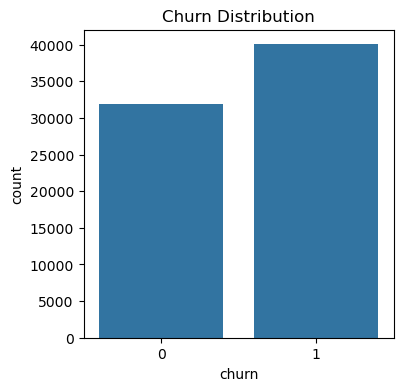

churn
1    0.557072
0    0.442928
Name: proportion, dtype: float64


In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
sns.countplot(data=df_tree, x='churn')
plt.title('Churn Distribution')
plt.show()

print(df_tree['churn'].value_counts(normalize=True))

## 이상치 탐색

<Axes: xlabel='bill_avg'>

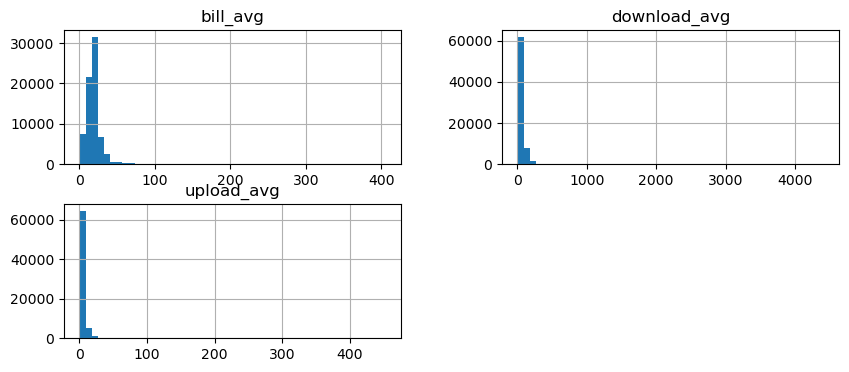

In [92]:
# 이상치 탐색
df_tree[['bill_avg', 'download_avg', 'upload_avg']].describe()
df_tree[['bill_avg', 'download_avg', 'upload_avg']].hist(bins=50, figsize=(10,4))
sns.boxplot(data=df_tree, x='bill_avg')
sns.boxplot(data=df_tree, x='download_avg')

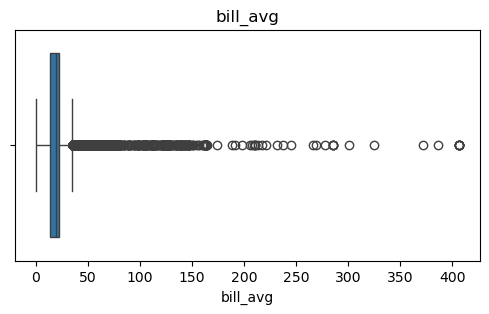

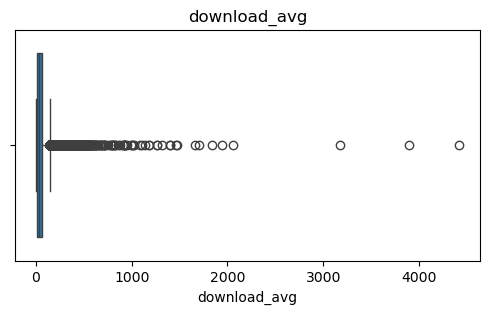

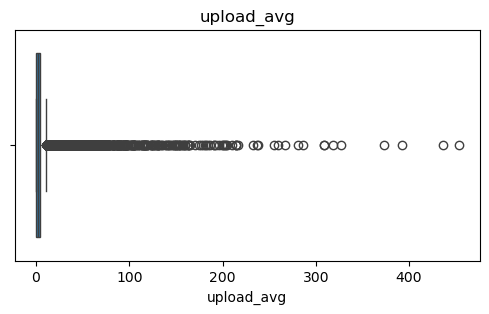

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = ['bill_avg', 'download_avg', 'upload_avg']

for col in num_cols:
    plt.figure(figsize=(6,3))
    sns.boxplot(data=df_tree, x=col)
    plt.title(f'{col}')
    plt.show()

In [94]:
Q1 = df_tree['bill_avg'].quantile(0.25)
Q3 = df_tree['bill_avg'].quantile(0.75)
IQR = Q3 - Q1
outliers = df_tree[(df_tree['bill_avg'] < Q1 - 1.5*IQR) | (df_tree['bill_avg'] > Q3 + 1.5*IQR)]
print(len(outliers))

Q1 = df_tree['download_avg'].quantile(0.25)
Q3 = df_tree['download_avg'].quantile(0.75)
IQR = Q3 - Q1
outliers = df_tree[(df_tree['download_avg'] < Q1 - 1.5*IQR) | (df_tree['download_avg'] > Q3 + 1.5*IQR)]
print(len('download_avg'))

Q1 = df_tree['upload_avg'].quantile(0.25)
Q3 = df_tree['upload_avg'].quantile(0.75)
IQR = Q3 - Q1
outliers = df_tree[(df_tree['upload_avg'] < Q1 - 1.5*IQR) | (df_tree['upload_avg'] > Q3 + 1.5*IQR)]
print(len(outliers))

3361
12
4864


### 로그변환
전체적으로 Skew가 심함

In [95]:
import numpy as np

for col in ['bill_avg', 'download_avg', 'upload_avg']:
    df_tree[f'{col}_log'] = np.log1p(df_tree[col])  # log(1+x)으로 0 방지

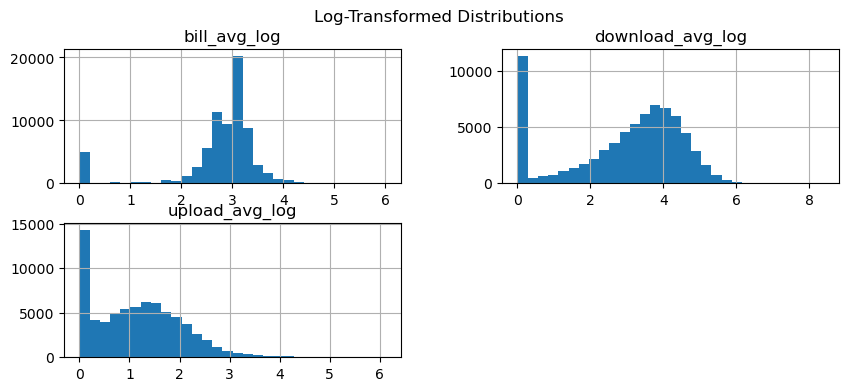

In [96]:
df_tree[[f'{col}_log' for col in ['bill_avg', 'download_avg', 'upload_avg']]].hist(bins=30, figsize=(10,4))
plt.suptitle('Log-Transformed Distributions')
plt.show()

| 변수                   | 변환 전 특징                       | 변환 후 특징               | 해석                          |
| -------------------- | ----------------------------- | --------------------- | --------------------------- |
| **bill_avg_log**     | 심한 오른쪽 꼬리(long right tail) 분포 | 약간의 오른쪽 비대칭만 남음       | 요금 데이터의 극단값(고요금 고객) 영향이 줄어듦 |
| **download_avg_log** | 대부분이 0~100 사이에 몰림, 극단값 많음     | 완만한 종 모양(near-normal) | 다운로드 량 값이 넓게 퍼져 정규성 개선     |
| **upload_avg_log**   | 0 근처 값이 많고 일부 극단값             | 여전히 오른쪽 꼬리 있으나 완화됨    | 업로드 량 스케일 안정화         |

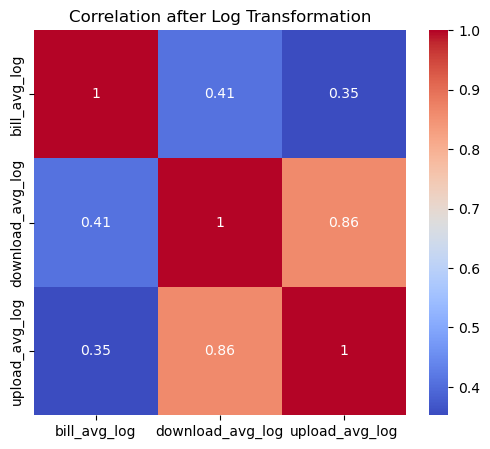

In [97]:
# Log 변환 후 변수 간 상관관계 확인
plt.figure(figsize=(6,5))
sns.heatmap(df_tree[[f'{col}_log' for col in ['bill_avg', 'download_avg', 'upload_avg']]].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation after Log Transformation')
plt.show()

download_avg가 높을 수록, upload_avg가 높다.

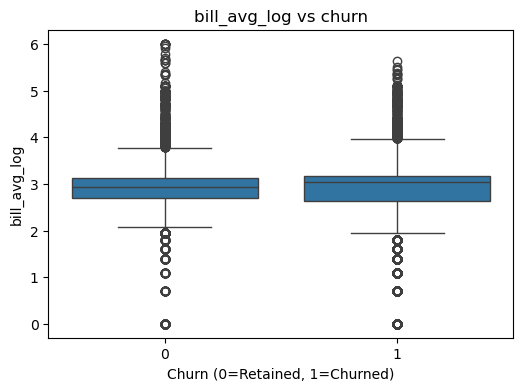

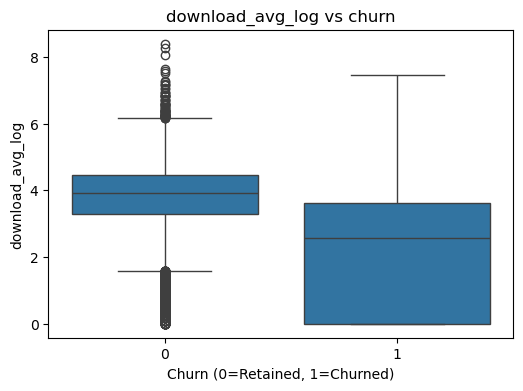

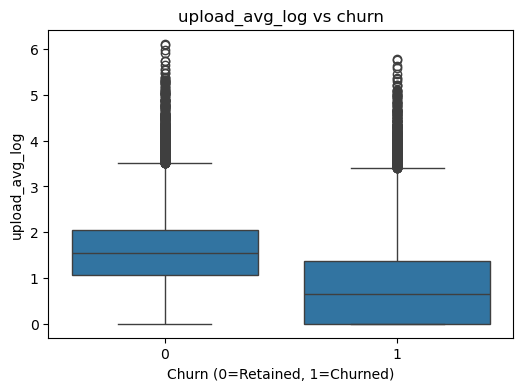

In [98]:
# 각 변수와 churn와의 관계
log_cols = ['bill_avg_log', 'download_avg_log', 'upload_avg_log']

for col in log_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df_tree, x='churn', y=col)
    plt.title(f'{col} vs churn')
    plt.xlabel('Churn (0=Retained, 1=Churned)')
    plt.ylabel(col)
    plt.show()

In [99]:
log_mean_diff = df_tree.groupby('churn')[log_cols].mean()
display(log_mean_diff)

,bill_avg_log,download_avg_log,upload_avg_log
churn,,,
0,2.919621,3.811645,1.588714
1,2.642485,2.225826,0.829202


- bill_avg가 낮을수록 이탈하는 경향을 보임(청구 금액이 적음 -> 이탈up)
- download_avg와 upload_avg가 낮을수록 이탈하는 경향을 보임 (인터넷 활동이 적음 -> 이탈up)

In [100]:
# 애매한 bill_avg에 대해 탐색
# 통계적으로 검정
from scipy.stats import ttest_ind

retained = df_tree[df_tree['churn'] == 0]['bill_avg_log']
churned = df_tree[df_tree['churn'] == 1]['bill_avg_log']

t_stat, p_val = ttest_ind(retained, churned, equal_var=False)
print("t-statistic:", t_stat)
print("p-value:", p_val)

t-statistic: 47.478349680875795
p-value: 0.0


In [101]:
# 방향성 확인
corr = df_tree[['bill_avg_log', 'churn']].corr().iloc[0,1]
print(f"Correlation (bill_avg_log vs churn): {corr:.3f}")

Correlation (bill_avg_log vs churn): -0.161


- t-검정: 두 집단(유지 vs 이탈)의 평균 차이가 큼
- p-value: 통계적으로 유의)
- bill_avg가 높을수록 이탈 확률이 낮은 경향
- 관계는 약하지만 음의 상관관계

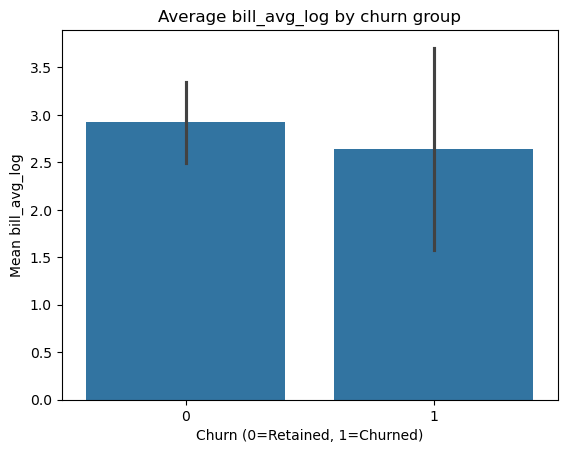

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=df_tree, x='churn', y='bill_avg_log', estimator='mean', errorbar='sd')
plt.title('Average bill_avg_log by churn group')
plt.xlabel('Churn (0=Retained, 1=Churned)')
plt.ylabel('Mean bill_avg_log')
plt.show()

고객 요금(bill_avg)이 낮은 그룹일수록 이탈 가능성이 높음
— 낮은 요금제 이용자는 서비스에 대한 충성도가 낮고, 쉽게 해지하거나 이동하는 경향이 있을 수 있음.
- churn=0(유지)의 막대가 더 높다. → 요금 높을수록 유지함

In [103]:
mean_diff = df_tree.groupby('churn')['bill_avg_log'].mean().diff().iloc[-1]
print(f"평균 차이: {mean_diff:.3f}")

평균 차이: -0.277


이탈 고객의 bill_avg_log가 유지 고객보다 평균적으로 0.277 낮다.
<br>
[총정리]
- 박스플롯에서는 겹쳐 보였지만, 통계적으로는 유의한 차이가 존재함
- bill_avg가 높은 고객은 서비스에 오래 남을 가능성이 크고, bill_avg가 낮은 고객은 이탈할 가능성이 높다.

## 범주형 변수 ~ churn 관계

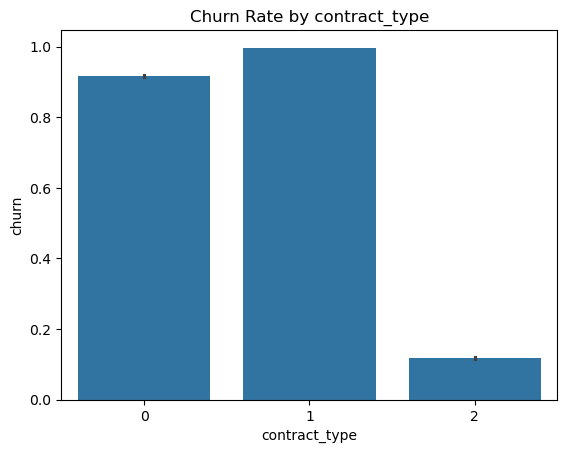

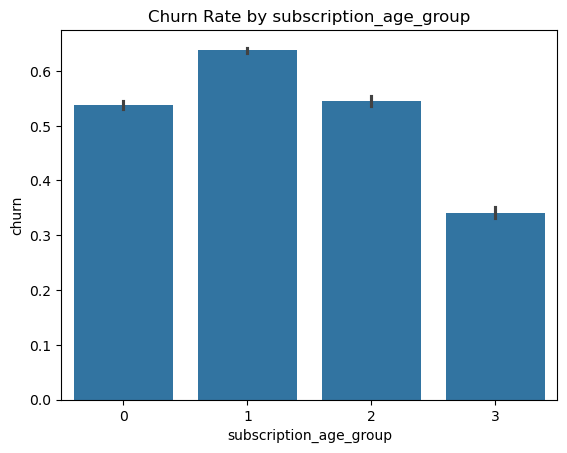

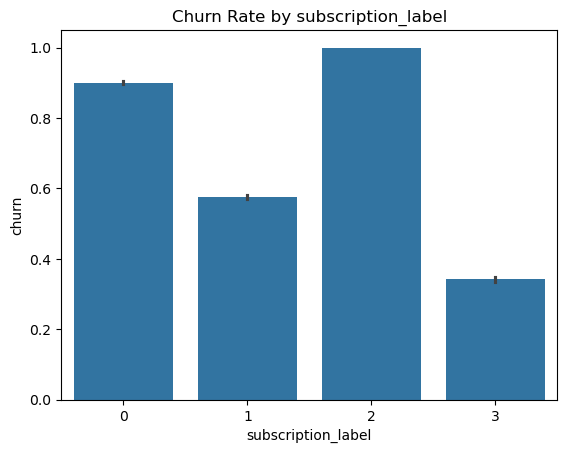

In [104]:
cat_cols = ['contract_type', 'subscription_age_group', 'subscription_label']
for col in cat_cols:
    sns.barplot(data=df_tree, x=col, y='churn', estimator='mean')
    plt.title(f'Churn Rate by {col}')
    plt.show()

- contrac_type=2 -> a**ctive**일수록, 이탈 비율이 낮음.
- subscription_age_group=3 -> **충성고객**일수록, 이탈 비율이 낮음.
- subscription_label= 1,3 -> **only tv, both** 일수록, 이탈 비율이 낮음.
```
- 이탈률 분석 결과,
약정 유지 고객(active), 충성 고객(5년 이상),
TV와 영화 구독자(both) 의 churn 비율이 현저히 낮은 것으로 나타남.
- 이는 약정 기간, 서비스 충성도, 콘텐츠 결합 정도가 고객 유지에 중요한 요인임을 시사
- 따라서 신규 고객 대상의 초기 이탈 방지 캠페인, 약정 갱신 혜택 제공,
TV·영화 결합 상품 확대가 실질적인 churn 감소 전략으로 쓰일 수 있음
```

### 교차분석

In [105]:
# 각 범주별 이탈률(%) 확인
cat_cols = ['contract_type', 'subscription_age_group', 'subscription_label']

for col in cat_cols:
    churn_rate = df_tree.groupby(col)['churn'].mean().reset_index()
    churn_rate['churn'] = churn_rate['churn'] * 100  # %
    print(f"\n< {col} >별 이탈률(%)")
    display(churn_rate)



< contract_type >별 이탈률(%)


,contract_type,churn
0,0,91.639558
1,1,99.559983
2,2,11.875570



< subscription_age_group >별 이탈률(%)


,subscription_age_group,churn
0,0,53.759189
1,1,63.743384
2,2,54.477864
3,3,34.130625



< subscription_label >별 이탈률(%)


,subscription_label,churn
0,0,90.076048
1,1,57.498410
2,2,100.000000
3,3,34.116177


#### label & contract_type

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

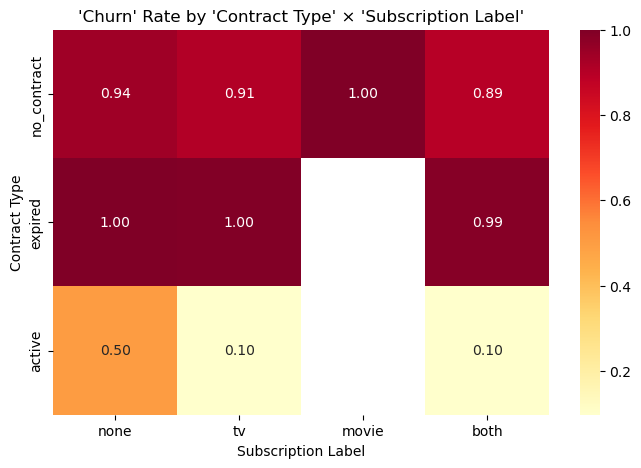

In [107]:
# 교차분석
# '약정상태 X 구독 조합' -> '이탈'에 주는 영향
cross_tab = df_tree.pivot_table(
    index='contract_type',
    columns='subscription_label',
    values='churn',
    aggfunc='mean'
)

contract_labels = {0: 'no_contract', 1: 'expired', 2: 'active'}
sub_label_labels = {0: 'none', 1: 'tv', 2: 'movie', 3: 'both'}

cross_tab.rename(index=contract_labels, columns=sub_label_labels, inplace=True)

plt.figure(figsize=(8, 5))
sns.heatmap(cross_tab, annot=True, fmt=".2f", cmap="YlOrRd")
plt.title("'Churn' Rate by 'Contract Type' × 'Subscription Label'")
plt.xlabel('Subscription Label')
plt.ylabel('Contract Type')
plt.show()

| 구독 형태               | 계약 상태       | 이탈률      | 해석 요약                             |
| ------------------- | ----------- | -------- | --------------------------------- |
| **none (구독 없음)**    | expired     | **100%** | 이미 계약이 끝난 고객으로, 서비스 종료 상태(완전 이탈) |
|                     | no_contract | **94%**  | 자유 구독자 대부분이 이탈(유지 장치 부족)         |
|                     | active      | **50%**  | 일부는 잔여 계약 기간 덕분에 유지 중            |
| **tv**              | expired     | **100%** | 계약이 끝난 사용자는 예외 없이 이탈             |
|                     | no_contract | **91%**  | 무약정 고객의 유지율이 낮음         |
|                     | active      | **10%**  | 계약이 유지되는 동안 이탈 방지 효과 뚜렷         |
| **movie**           | no_contract | **100%** | 무약정 고객이 이용하는 영화 구독 전원 이탈 (충성도 낮음) |
| **both (tv+movie)** | expired     | **99%**  | 계약 만료 시 거의 모두 이탈                    |
|                     | no_contract | **89%**  | 무약정 고객 대부분 이탈                   |
|                     | active      | **10%**  | 약정 고객 안정적으로 유지 중                |

#### age_group & contract_type
- 구독 시간이 흐를 수록(x) 계약 상태(y)

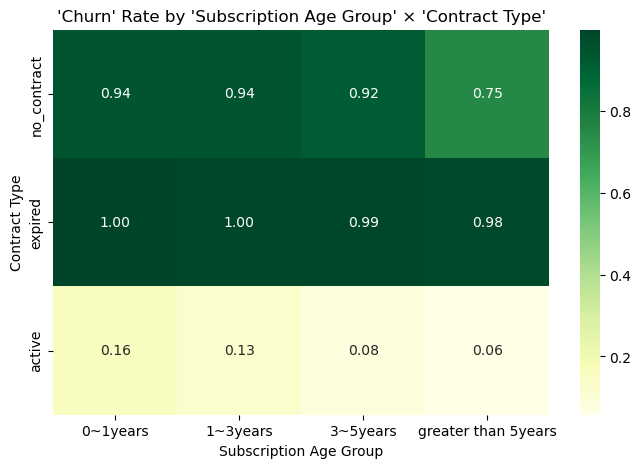

In [108]:
cross_tab2 = df_tree.pivot_table(
    index='contract_type',
    columns='subscription_age_group',
    values='churn',
    aggfunc='mean'
)

contract_labels = {0: 'no_contract', 1: 'expired', 2: 'active'}
age_labels = {0: '0~1years', 1: '1~3years', 2: '3~5years', 3: 'greater than 5years'}

cross_tab2.rename(index=contract_labels, columns=age_labels, inplace=True)

plt.figure(figsize=(8, 5))
sns.heatmap(cross_tab2, annot=True, fmt=".2f", cmap="YlGn")
plt.title("'Churn' Rate by 'Subscription Age Group' × 'Contract Type'")
plt.xlabel('Subscription Age Group')
plt.ylabel('Contract Type')
plt.show()


| 구독 연수     | 계약 상태       | 이탈률(%)  | 해석 요약                    |
| --------- | ----------- | ------- | ------------------------ |
| **0~1년**  | active      | **16**  | 약정이 있으면 초기 고객도 유지 가능     |
|           | expired     | **100** | 약정 종료 즉시 대부분 이탈          |
|           | no_contract | **94**  | 자유이용 고객 대부분 이탈           |
| **1~3년**  | active      | **13**  | 약정 유지 고객 충성도 상승          |
|           | expired     | **100** | 약정 만료 → 즉시 이탈            |
|           | no_contract | **94**  | 단기 이용 후 이탈               |
| **3~5년**  | active      | **8**   | 장기 고객으로 안정적 유지           |
|           | expired     | **99**  | 약정 종료 시 거의 이탈            |
|           | no_contract | **92**  | 약정 없으면 여전히 불안정           |
| **5년 이상** | active      | **6**   | 매우 안정적인 충성 고객            |
|           | expired     | **98**  | 만료 즉시 이탈                 |
|           | no_contract | **75**  | 장기 고객이라도 약정이 없으면 유지율 떨어짐 |


① 구독 연수(Subscription Age Group)

- 연수가 증가할수록 (`0~1년` → `5년 이상`)
이탈률이 일관되게 감소함

  → 서비스 이용 기간이 길수록 고객 충성도가 증가한다.

② 계약 상태(Contract Type)

- 약정이 `active`일 때 이탈률이 가장 낮음
- 약정이 `expired`면 거의 전원 이탈 (100%) — 계약 갱신 실패 고객군
- `no_contract` 역시 매우 높은 이탈률 → 자유 이용 고객의 불안정성


#### label & age_group

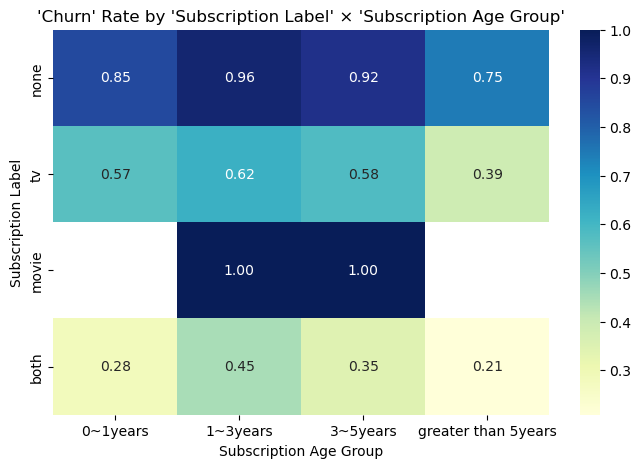

In [109]:
# subscription_label과 subscription_age_group의 상관관계
cross_tab3 = df_tree.pivot_table(
    index='subscription_label',            # 구독 조합
    columns='subscription_age_group',      # 구독 연수
    values='churn',
    aggfunc='mean'
)

# 라벨링
sub_labels = {0: 'none', 1: 'tv', 2: 'movie', 3: 'both'}
age_labels = {0: '0~1years', 1: '1~3years', 2: '3~5years', 3: 'greater than 5years'}
cross_tab3.rename(index=sub_labels, columns=age_labels, inplace=True)

plt.figure(figsize=(8, 5))
sns.heatmap(cross_tab3, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("'Churn' Rate by 'Subscription Label' × 'Subscription Age Group'")
plt.xlabel('Subscription Age Group')
plt.ylabel('Subscription Label')
plt.show()


| 구독 연수     | 구독 조합 | 이탈률(%)   | 해석 요약                          |
| --------- | ----- | -------- | ------------------------------ |
| **0~1년**  | both  | **28%**  | 복합 구독 고객은 초반부터 충성도 높음, 비교적 안정적 |
|           | movie | -        | 데이터 없음          |
|           | tv    | **57%**  | 단일 구독 고객의 절반 이상 이탈, 유지율 낮음     |
|           | none  | **85%**  | 구독 없음 고객 대부분 이탈, 초기 이탈 집중      |
| **1~3년**  | both  | **45%**  | 결합 구독에도 중기 이탈 존재, 장기화 시 개선 가능  |
|           | movie | **100%** | 영화 단독 구독자는 거의 모두 이탈            |
|           | tv    | **62%**  | 중기 단일 구독자도 여전히 불안정             |
|           | none  | **96%**  | 구독 없음 고객은 유지율 극히 낮음            |
| **3~5년**  | both  | **35%**  | 장기 복합 구독 고객은 안정화 단계 진입         |
|           | movie | **100%** | 영화 단독 구독자의 유지 불가 (서비스 충성도 낮음)  |
|           | tv    | **58%**  | 단일 구독자는 여전히 높은 churn           |
|           | none  | **92%**  | 구독 없음 고객 대부분 이탈 유지             |
| **5년 이상** | both  | **21%**  | 매우 낮은 이탈률 — 충성 고객층 형성          |
|           | movie | -        | 데이터 없음         |
|           | tv    | **39%**  | 장기 TV 구독자는 절반 이하 수준으로 안정화      |
|           | none  | **75%**  | 장기 이용자라도 구독 없음 고객은 churn 지속    |

<br>

<패턴요약>
| 관점                   | 패턴                         | 해석                         |
| -------------------- | -------------------------- | -------------------------- |
| **복합 구독 (both)**     | 전 연령대에서 가장 낮은 이탈률 (21~45%) | 결합 상품 이용자는 높은 서비스 몰입도와 충성도 |
| **단일 구독 (tv/movie)** | 평균 이탈률 50~100%             | 단일 구독 고객은 유지율 낮고 이탈 위험 높음  |
| **구독 없음 (none)**     | 75~96%로 항상 최고 이탈률          | 서비스 의존도 낮아 장기 유지 어려움       |
| **구독 연수 효과**         | 연수가 길수록 전반적으로 이탈률↓         | 장기 고객은 서비스 적응·충성도 상승       |
| **복합 효과**            | (연수↑ × 복합 구독) → churn 급감   | 장기 복합 구독자는 핵심 유지 고객층       |

<br>

- 구독 연수와 구독 조합은 churn에 대해 뚜렷한 상호작용 관계를 가짐
- 복합 구독(both) 고객은 전 기간에 걸쳐 이탈률이 가장 낮았으며,
구독 기간이 길수록 이탈률은 추가로 감소함
- 반면, 단일 구독(tv/movie) or 구독 없음(none)은
기간이 길어도 높은 이탈률을 유지
- 이는 복합 구독 유도와 초기 고객 리텐션 관리가 churn 감소의 핵심 전략임을 의미함.



## 서비스 불만 ~ churn 관련

In [110]:
df_tree.describe()

,bill_avg,service_failure_count,download_avg,upload_avg,download_over_limit,churn,contract_type,subscription_age_group,subscription_label,bill_avg_log,download_avg_log,upload_avg_log
count,71892.000000,71892.000000,71892.000000,71892.000000,71892.000000,71892.000000,71892.000000,71892.000000,71892.000000,71892.000000,71892.000000,71892.000000
mean,19.017109,0.275677,43.690066,4.192116,0.208716,0.557072,1.173775,1.144981,1.483378,2.765236,2.928230,1.165612
std,13.188442,0.818539,63.406391,9.818959,0.999654,0.496736,0.861515,0.963032,1.134592,0.855281,1.604201,0.888314
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.000000,0.000000,6.700000,0.500000,0.000000,0.000000,0.000000,0.000000,1.000000,2.639057,2.041220,0.405465
50%,19.000000,0.000000,27.800000,2.100000,0.000000,1.000000,1.000000,1.000000,1.000000,2.995732,3.360375,1.131402
75%,22.000000,0.000000,60.500000,4.800000,0.000000,1.000000,2.000000,2.000000,3.000000,3.135494,4.119037,1.757858
max,406.000000,19.000000,4415.200000,453.300000,7.000000,1.000000,2.000000,3.000000,3.000000,6.008813,8.393035,6.118758


#### service_failure & churn

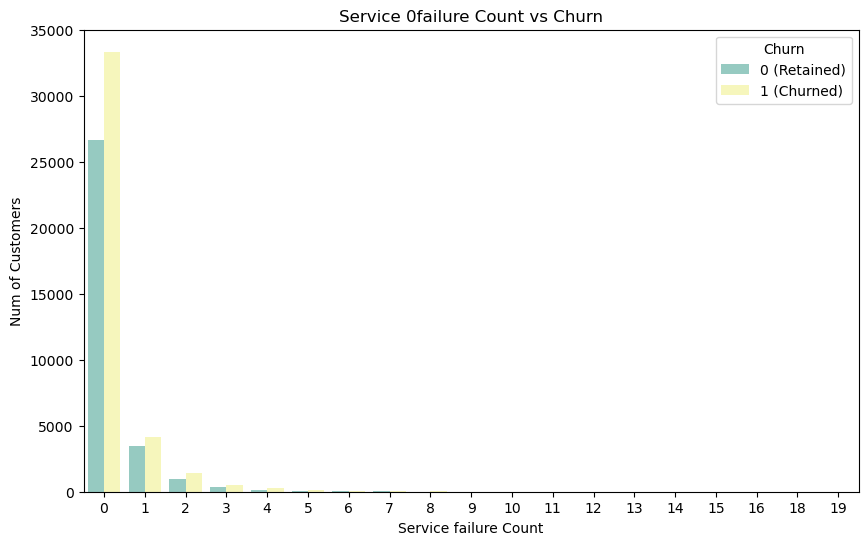

In [111]:
plt.figure(figsize=(10, 6))

sns.countplot(data=df_tree, x='service_failure_count', hue='churn', palette='Set3')

plt.title('Service 0failure Count vs Churn')
plt.xlabel('Service failure Count')
plt.ylabel('Num of Customers')

plt.legend(title='Churn', labels=['0 (Retained)', '1 (Churned)'])
plt.show()

**1. 분포 형태**
- 두 집단(churn=0 유지, churn=1 이탈) 모두
대부분의 데이터가 0 근처에 밀집되어 있음
- 즉, **대부분 고객은 서비스 장애 경험이 거의 없다.**
- 하지만 소수의 고객이 장애를 여러 번(Max 19회) 경험한 극단치(outlier) 존재 => → 전체 고객 중 극소수의 불만 집중 고객군 존재

**2. Median**
- 두 그룹 모두 중앙값은 0으로 동일함.
    → 평균적인 고객 수준에서는 churn에 큰 차이가 없음.
- 하지만 박스플롯 상단(상위 25%) 영역에서 이탈 고객(churn=1) 그룹이 더 넓게 퍼져 있음 → **일부 이탈 고객들이 유지 고객보다 더 많은 장애를 경험했음**을 의미

**3. Outlier 분포**
- 두 그룹 모두 이상치가 많지만, 이탈 고객 그룹(churn=1) 의 이상치 빈도가 더 높음
- 특히 service_failure_count = 12, 16 고객 중 일부는 contract_type=2(active) 상태에서 이탈하지 않음 → 약정 계약으로 인해 불만이 있어도 해지하지 못한 고객층 존재

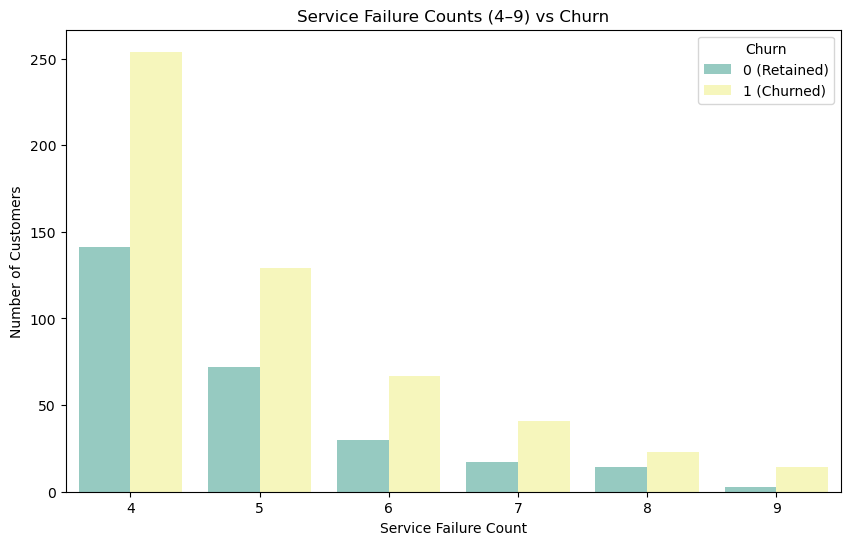

In [112]:
# service_failure_counts (4~9) 확대
plt.figure(figsize=(10,6))

subset = df_tree[(df_tree['service_failure_count'] >= 4) &
                 (df_tree['service_failure_count'] <= 9)]

sns.countplot(data=subset, x='service_failure_count', hue='churn', palette='Set3')
plt.title('Service Failure Counts (4–9) vs Churn')
plt.xlabel('Service Failure Count')
plt.ylabel('Number of Customers')
plt.legend(title='Churn', labels=['0 (Retained)', '1 (Churned)'])
plt.show()

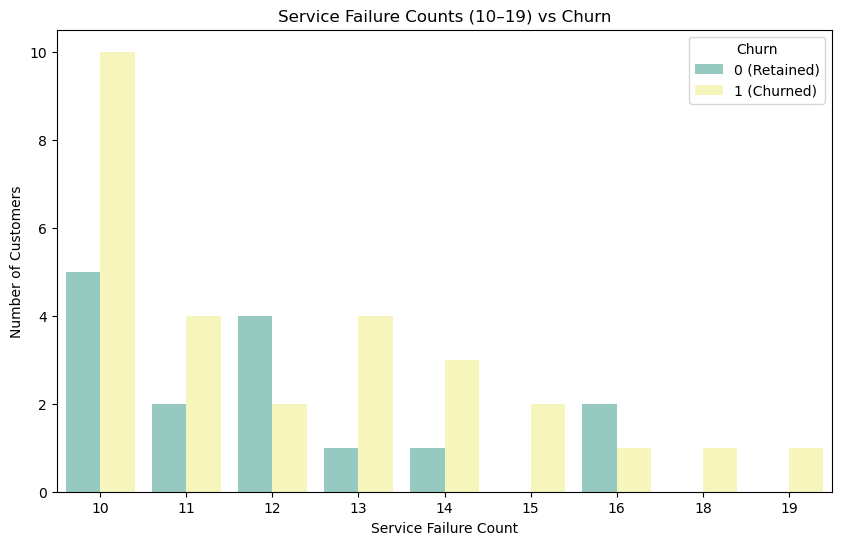

In [113]:
# service_failure_counts (10~19) 확대
plt.figure(figsize=(10,6))

subset = df_tree[(df_tree['service_failure_count'] >= 10) &
                 (df_tree['service_failure_count'] <= 19)]

sns.countplot(data=subset, x='service_failure_count', hue='churn', palette='Set3')
plt.title('Service Failure Counts (10–19) vs Churn')
plt.xlabel('Service Failure Count')
plt.ylabel('Number of Customers')
plt.legend(title='Churn', labels=['0 (Retained)', '1 (Churned)'])
plt.show()

service_failure_count = 12, 16 -> 이탈 고객 보다 유지 고객이 더 많음.  => 탐색 필요

In [114]:
# service_failure_count=12인 row
df_tree[df_tree['service_failure_count'].isin([12])]

,bill_avg,service_failure_count,download_avg,upload_avg,download_over_limit,churn,contract_type,subscription_age_group,subscription_label,bill_avg_log,download_avg_log,upload_avg_log
25046,71,12,344.8,60.9,0,0,2,3,3,4.276666,5.845861,4.125520
30311,35,12,12.0,1.0,0,1,1,0,1,3.583519,2.564949,0.693147
35831,12,12,89.5,4.7,0,1,1,0,1,2.564949,4.505350,1.740466
50335,20,12,108.2,17.4,0,0,2,1,3,3.044522,4.693181,2.912351
61656,58,12,89.9,12.2,0,0,2,0,0,4.077537,4.509760,2.580217
66445,61,12,92.9,21.1,0,0,2,0,3,4.127134,4.542230,3.095578


In [115]:
# service_failure_count=16인 row
df_tree[df_tree['service_failure_count'].isin([16])]

,bill_avg,service_failure_count,download_avg,upload_avg,download_over_limit,churn,contract_type,subscription_age_group,subscription_label,bill_avg_log,download_avg_log,upload_avg_log
36674,12,16,53.5,1.9,0,0,2,2,3,2.564949,3.998201,1.064711
43729,56,16,122.1,20.8,0,1,0,1,1,4.043051,4.812997,3.081910
65046,18,16,44.4,2.1,0,0,2,0,3,2.944439,3.815512,1.131402


서비스 장애가 많이 발생해도, contract_type=2(active)인 고객이 이탈하지 않음. => 약정때문에 해지하지 않은 것으로 보임

In [116]:
# 평균 차이 검정
from scipy.stats import ttest_ind

churned = df_tree[df_tree['churn']==1]['service_failure_count']
retained = df_tree[df_tree['churn']==0]['service_failure_count']

t, p = ttest_ind(churned, retained, equal_var=False)
print(f"t-statistic: {t:.3f}, p-value: {p:.5f}")

t-statistic: 5.361, p-value: 0.00000


- **이탈 고객(churn=1)이** 유지 고객(churn=0)에 비해
**평균적으로 더 많은 서비스 장애(service_failure_count)를 경험했다.**
- 통계적으로 유의(실질적으로 유의한 차이)

#### download_over & churn

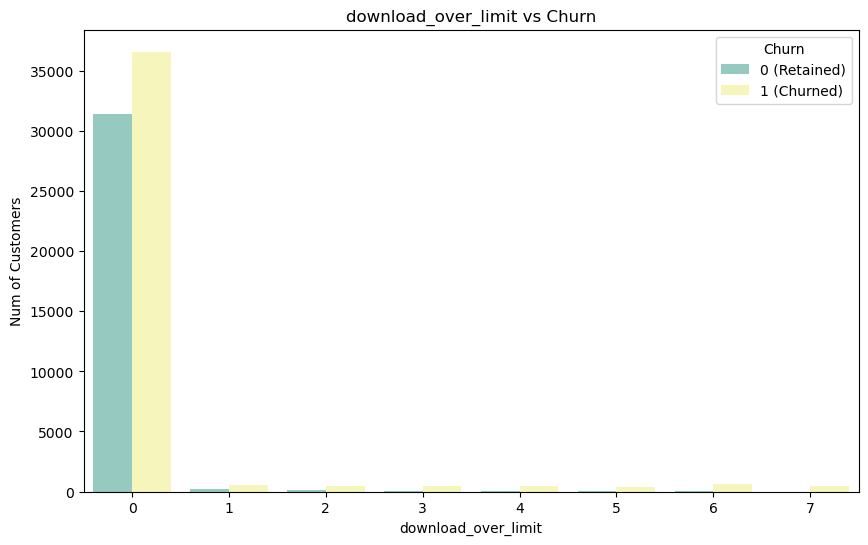

In [117]:
plt.figure(figsize=(10, 6))

sns.countplot(data=df_tree, x='download_over_limit', hue='churn', palette='Set3')

plt.title('download_over_limit vs Churn')
plt.xlabel('download_over_limit')
plt.ylabel('Num of Customers')

plt.legend(title='Churn', labels=['0 (Retained)', '1 (Churned)'])
plt.show()

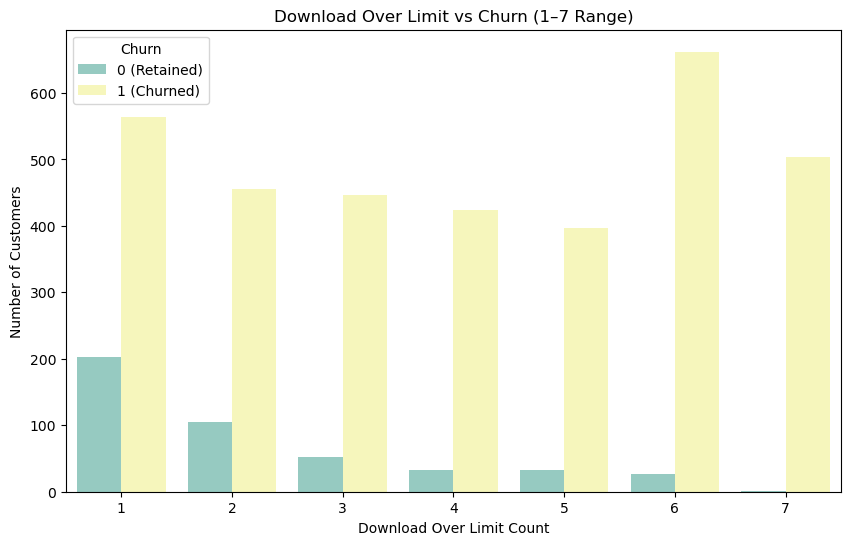

In [118]:
# service_failure_counts (1~7) 확대
plt.figure(figsize=(10,6))

subset = df_tree[(df_tree['download_over_limit'] >= 1) &
                 (df_tree['download_over_limit'] <= 7)]

sns.countplot(data=subset, x='download_over_limit', hue='churn', palette='Set3')

plt.title('Download Over Limit vs Churn (1–7 Range)')
plt.xlabel('Download Over Limit Count')
plt.ylabel('Number of Customers')
plt.legend(title='Churn', labels=['0 (Retained)', '1 (Churned)'])
plt.show()


In [119]:
# 다운로드 초과 횟수에 따른 이탈률 비율
churn_rate = pd.crosstab(df_tree['download_over_limit'], df_tree['churn'], normalize='index') * 100
churn_rate

churn,0,1
download_over_limit,,
0,46.172288,53.827712
1,26.370757,73.629243
2,18.750000,81.250000
3,10.441767,89.558233
4,7.017544,92.982456
5,7.459207,92.540793
6,3.779070,96.220930
7,0.198413,99.801587


/var/folders/2x/_p089hqd08j6vdcht5q7h27w0000gn/T/ipykernel_14617/23797472.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


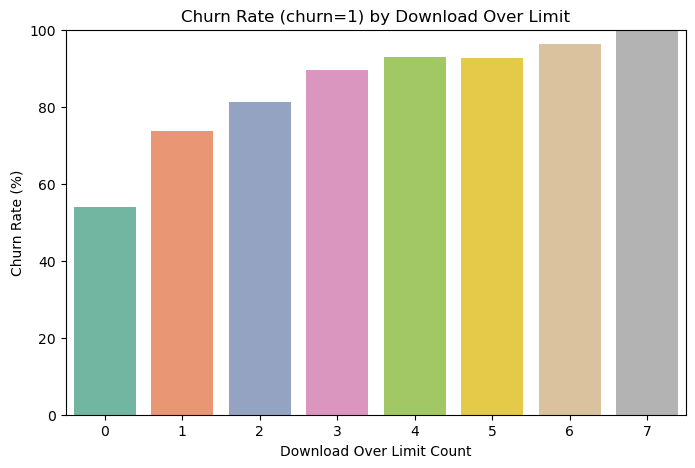

In [120]:
# 다운로드 초과 횟수에 따른 이탈률 시각화
plt.figure(figsize=(8,5))
sns.barplot(
    x=churn_rate.index,
    y=churn_rate[1],     # churn=1 열만 선택
    palette='Set2'
)
plt.title('Churn Rate (churn=1) by Download Over Limit')
plt.xlabel('Download Over Limit Count')
plt.ylabel('Churn Rate (%)')
plt.ylim(0, 100)
plt.show()


- `다운로드 초과 횟수가 0회` 인 고객군은 이탈(churn=1)과 유지(churn=0) 비율이 거의 유사함
- `초과 횟수가 1회 이상` 인 고객군부터는 명확한 차이가 발생 <br>
    → 특히  `초과 횟수가 증가할수록` **이탈률이 상승** 하는 경향

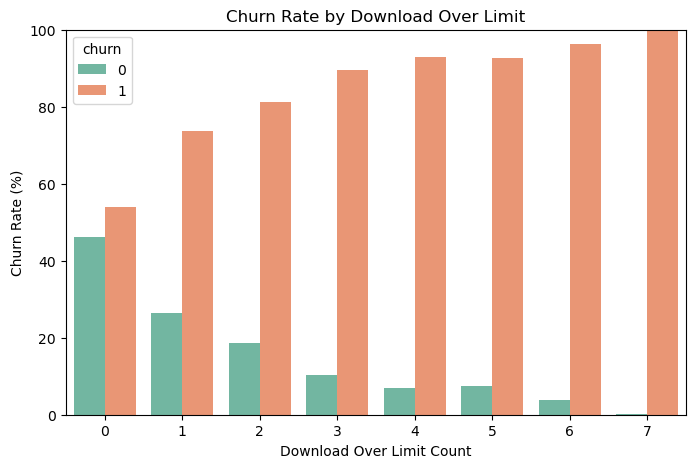

In [121]:
churn_rate_melted = churn_rate.reset_index().melt(
    id_vars='download_over_limit',
    var_name='churn',
    value_name='Churn Rate'
)

plt.figure(figsize=(8,5))
sns.barplot(
    data=churn_rate_melted,
    x='download_over_limit',
    y='Churn Rate',
    hue='churn',
    palette='Set2'
)
plt.title('Churn Rate by Download Over Limit')
plt.xlabel('Download Over Limit Count')
plt.ylabel('Churn Rate (%)')
plt.ylim(0, 100)
plt.show()

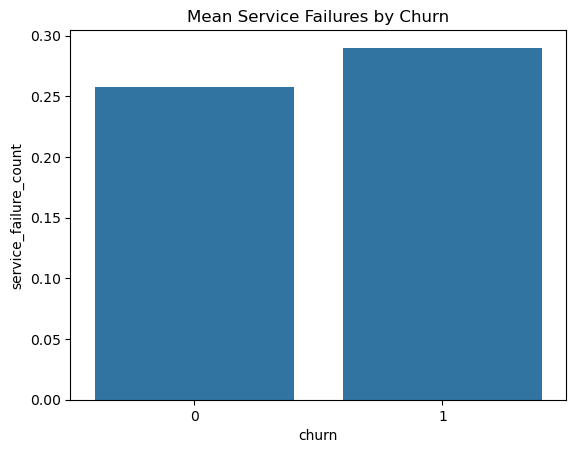

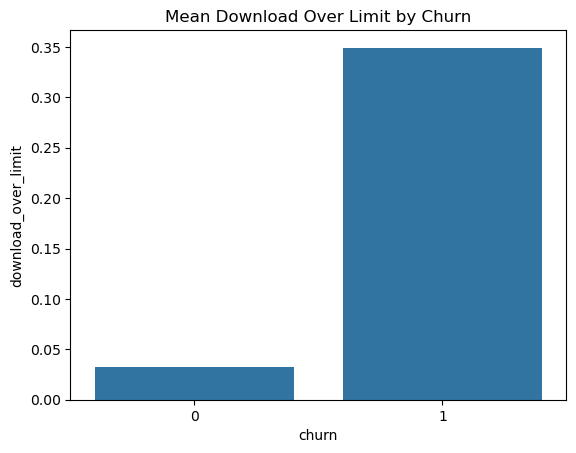

In [122]:
sns.barplot(
    data=df_tree, x='churn',
    y='service_failure_count', estimator='mean', errorbar=None
)
plt.title('Mean Service Failures by Churn')
plt.show()

sns.barplot(
    data=df_tree, x='churn',
    y='download_over_limit', estimator='mean', errorbar=None
)
plt.title('Mean Download Over Limit by Churn')
plt.show()

이탈고객(churn=1)이 서비스 장애를 더 경험했고, 다운로드 초과 횟수를 훨씬 많이 경험함

# ☀ 총정리

## _계약 기간, 구독 형태, 요금·사용량 기반 이탈_

**1. 약정 기간(subscription_age_group)과 이탈률 관계**
| 구간    | 고객 비율 | 이탈률   | 특징                  |
| ----- | ----- | ----- | ------------------- |
| 0~1년  | 27.4% | 높음    | 초기 고객군 — 온보딩 실패 가능성 |
| 1~3년  | 43.4% | 매우 높음 | 약정 만료 구간, 이탈 집중     |
| 3~5년  | 16.5% | 낮음    | 재계약 고객 — 안정화 구간     |
| 5년 초과 | 12.7% | 매우 낮음 | 충성 고객층 형성           |
```
  <분석 결과>
  - 전체 고객 중 1~3년 구간이 가장 많으며, 이 구간의 이탈률이 가장 높다.
  - 이는 기본 약정 기간(1~3년) 이 만료되는 시점에서 재계약 유도나 서비스 만족도 관리가 미흡함을 알 수 있다.

  <문제점>
  - 약정 종료 후 갱신 프로세스 부재 → 고객 이탈로 직접 연결
  - 신규 고객(0~1년)은 초기 경험 문제로 churn 위험 높음

  <시사점>
  - 1~3년차 고객 대상 “재계약 프로모션” 필요
  - 0~1년차 고객 대상 온보딩·체험 관리 강화
  - 장기 고객(5년 이상) 대상 리워드·혜택 유지로 충성도 유지

```

**2. 구독 형태(subscription_label)와 이탈률 관계**
| 구독 형태           | 고객 수    | 특징         | 이탈률 추세              |
| --------------- | ------- | ---------- | ------------------- |
| TV만 구독 (tv)     | 34,954명 | 전체 중 가장 많음 | 유지 > 이탈 (약간의 차이)    |
| Both (tv+movie) | 24,015명 | 복합 구독 고객군  | 유지 고객이 이탈보다 약 2배 많음 |
| None (구독 없음)    | 13,281명 | 단일 서비스 이용  | 이탈 고객 비중 압도적        |
| Movie만 구독       | 2명      | 표본 거의 없음   | 통계적 의미 없음           |

```
<분석 결과>
- TV만 구독한 고객이 가장 많지만, 여전히 이탈률이 높다.
- 복합 구독 고객(Both) 은 churn 비율이 가장 낮고, 유지 고객이 많다.
- 구독 없음(None) 고객은 유지율이 가장 낮고 churn 집중되어 있다.

<문제점>
- 복합 구독 유도 정책 부재
- Movie 단독 상품 수요 및 유입 부족
- 구독 없음 고객군(None)은 서비스 체감도가 낮아 충성도 형성 어려움

<시사점>
- TV+영화 결합 상품(패키지) 프로모션 강화
- Movie 단일 구독 상품 개선 또는 폐합 검토
- 구독 없음 고객 대상 체험/추천 콘텐츠 제공 → 전환 유도
```

**3. 사용량(download_avg, upload_avg) 및 요금(bill_avg)과 이탈률**
| 변수             | 특징       | churn 경향 | 해석              |
| -------------- | -------- | -------- | --------------- |
| `bill_avg`     | 평균 청구 금액 | 낮을수록 이탈↑ | 낮은 요금제 고객 충성도↓  |
| `download_avg` | 다운로드 사용량 | 낮을수록 이탈↑ | 인터넷 이용률↓ → 관심도↓ |
| `upload_avg`   | 업로드 사용량  | 낮을수록 이탈↑ | 서비스 몰입도↓        |

```
<분석 결과>
- bill_avg_log 기준, 이탈 고객의 평균이 유지 고객보다 0.277 낮음
- t-검정 결과: p < 0.001 (통계적으로 유의) → 두 그룹(유지 vs 이탈)의 요금 수준에 유의한 차이 존재
- 상관관계: bill_avg_log ↔ churn = -0.161 (음의 관계) <br>
따라서,
- 요금이 낮을수록 이탈률이 높다. <br>
    → 저가 요금제 고객은 충성도 낮고, 타사 이동·해지 가능성 높음
- 사용량(download_avg, upload_avg)도 낮을수록 churn↑ <br>
    → 서비스 이용 빈도가 낮은 고객은 이탈 위험군

<문제점>
- 저가 요금제 고객군의 churn 집중
- 서비스 활용이 적은 고객 → 가치 체감도 낮음

<시사점>
- 저가 요금제 고객 전용 리텐션 프로그램(포인트/혜택) 필요
- 활동량 낮은 고객에게 맞춤형 사용 유도 캠페인 진행
- 프리미엄 요금제 고객 유지 정책 (장기 계약, 번들 혜택) 강화
```

---
위 분석 결과, 고객 이탈의 주요 요인은
- ① 약정 기간 만료 (1~3년차), ② 구독 부재(None), ③ 낮은 요금제(bill_avg) 로 나타났다.
- 특히 서비스 이용 빈도(download_avg, upload_avg)가 낮은 고객은
서비스 몰입도가 낮아 쉽게 해지하는 경향을 보였다.
- 따라서 **"약정 갱신 프로세스 강화 + 복합 구독 유도 + 저가 요금제 고객 관리"** 가 churn 감소의 핵심 전략으로 제시할 수 있다.

## _계약·구독 형태에 따른 고객 이탈(Churn) 패턴 분석_

**1. 계약 상태(contract_type)와 구독 형태(subscription_label)의 관계**
```
<분석 결과>
- 약정(active) 상태의 고객은 churn이 10% 이하로 매우 안정적이다.
- expired 상태 고객은 거의 전원(≈99~100%) 이탈
- no_contract 고객도 대부분 이탈 (≈90% 이상)
- 즉, 약정 유지 여부가 churn 방지의 핵심 요인

<문제점>
- 약정 만료 후 자동 재계약 또는 리마인드 정책 부재
- 무약정 고객군에 대한 유지 장치 부족
- 특히 “movie 단독 구독 + 무약정” 고객의 이탈률 100% → 서비스 충성도 매우 낮음

<시사점>
- 약정 만료 고객 대상 자동 갱신 제도 또는 인센티브 필요
- 무약정 고객 대상 단기 혜택 프로모션 도입으로 churn 방지
- 복합 구독(both) 고객 중심의 장기 계약 유도 정책이 가장 효과적
```

**2. 구독 연수(subscription_age_group)와 계약 상태(contract_type)의 관계**
```
<분석 결과>
- 약정(active) 상태 고객의 churn은 6~16% 수준으로 매우 낮다.
- expired/no_contract 고객군은 이탈률 90% 이상으로 일관되게 높다.
- 구독 연수가 길수록 churn 감소, 특히 5년 이상 장기 이용자는 충성도가 높다.

<문제점>
- 약정 만료 후 유지 전략이 전무함 → 계약 갱신 실패가 churn으로 직결
- 무약정 고객군은 서비스 충성도 형성이 어렵다.

<시사점>
- 만료 전 알림, 재계약 혜택, 장기 고객 보상 정책 필요
- 약정 유지와 서비스 이용기간을 함께 관리하는 체계가 핵심
- 0~1년 신규 고객 onboarding 관리 강화 → 초기 churn 완화
```

**3. 구독 연수(subscription_age_group)와 구독 조합(subscription_label)의 관계**
| 관점                   | 패턴                       | 해석                |
| -------------------- | ------------------------ | ----------------- |
| **복합 구독 (both)**     | 모든 구간에서 이탈률 최소 (21~45%)  | 서비스 몰입도·만족도 높음    |
| **단일 구독 (tv/movie)** | 이탈률 50~100%              | 단일 구독 고객은 유지율 낮음  |
| **구독 없음 (none)**     | 75~96%로 항상 최상위 이탈률       | 충성도 낮고 장기 유지 어려움  |
| **구독 연수 효과**         | 연수가 길수록 churn 감소         | 장기 고객의 서비스 적응 효과  |
| **복합 효과**            | (연수↑ × 복합 구독) → churn 급감 | 장기 복합 구독자는 핵심 충성층 |

```
<분석 결과>
- 복합 구독 고객(both) 은 모든 연령대에서 가장 낮은 이탈률을 보인다.
  → 콘텐츠 다양성과 결합 혜택이 churn 방지에 기여
- 단일 구독(tv/movie) 은 연수가 길어도 churn이 높다.
  → 서비스 가치가 낮거나 대체재가 많음
- 구독 없음(none) 고객은 초기·장기 모두 이탈 집중
  → 브랜드 충성도와 이용 빈도가 낮음
```

<문제점>

| 문제                           | 원인              | 영향            |
| ---------------------------- | --------------- | ------------- |
| 약정 만료 시 churn 100%           | 자동 갱신/리마인드 부재   | 계약 종료 → 즉시 이탈 |
| 무약정 고객 churn 90%↑            | 유지 정책 부재        | 불안정 고객층 형성    |
| 단일 구독(movie, tv) churn 높음    | 서비스 몰입도 부족      | 결합 상품 필요성 증가  |
| 초기(0~1년) churn 집중            | onboarding 약함   | 신규 고객 리텐션 실패  |
| 장기 고객이라도 약정·구독 없음 시 churn 지속 | 계약/서비스 가치 인식 저하 | 충성도 유지 실패     |


<br>

<시사점>
| 전략                         | 구체적 실행안            | 기대 효과                  |
| -------------------------- | ------------------ | ---------------------- |
| **1. 약정 만료 관리**            | 만료 전 알림 + 자동 갱신 혜택 | churn 99~100% 고객군 감소   |
| **2. 무약정 고객 유지 전략**        | 단기 프로모션, 맞춤 리마인드   | no_contract churn 완화   |
| **3. 복합 구독 확대 정책**         | 번들 할인, 콘텐츠 결합      | both 구독군 확장, churn 최소화 |
| **4. 신규 고객 onboarding 강화** | 가입 첫 1년간 체험/보상 제도  | 초기 churn 감소            |
| **5. 장기 고객 리워드 강화**        | 5년 이상 고객 대상 포인트/혜택 | 충성도 유지 및 추천 효과         |

---

- 고객 이탈(Churn)의 핵심 패턴은 “약정 종료 + 구독 부재 + 단기 이용자” 에 집중되어 있다.
- 반대로 “장기 이용 + 약정 유지 + 복합 구독” 고객군은 가장 충성도 높고 안정적이다.
- 따라서 향후 재계약 관리 시스템, 결합 구독 프로모션, 초기 고객 리텐션 프로그램이 churn을 줄이는 가장 효과적인 전략으로 제시할 수 있다.


## _서비스 품질 요인과 고객 이탈(Churn) 관계_


**1. Service Failure Count (서비스 장애 경험)**

  1.1. 분포 형태

- 두 집단(churn=0 유지 / churn=1 이탈) 모두 0 근처에 데이터가 밀집,
즉, 대부분의 고객은 최근 3개월 동안 서비스 장애 경험이 거의 없다.
- 그러나 일부 고객은 최대 19회까지 장애를 신고한 극단치(outlier)가 존재
→ 전체 고객 중 극소수의 불만 집중 고객군 존재

1.2. 중앙값(Median) 비교
- 두 그룹 모두 중앙값은 0으로 동일
  → 평균적인 고객 수준에서는 churn에 큰 차이가 없다.
- 하지만 박스플롯 상단(상위 25%) 영역에서 이탈 고객(churn=1) 그룹이 더 넓게 퍼져 있음
  → 일부 이탈 고객들이 유지 고객보다 더 많은 장애를 경험했음을 의미한다.

1.3. 이상치(Outlier) 분포
- 두 그룹 모두 이상치 존재하지만,
이탈 고객군의 이상치 빈도가 더 높다.
- 특히 service_failure_count = 12, 16 고객 중 일부는
contract_type=2(active) 상태에서 이탈하지 않음 →
약정 계약으로 인해 불만이 있어도 해지하지 못한 고객층 존재

4. 통계적 검정 결과
- t-statistic = 5.361, p-value < 0.001
→ 이탈 고객이 유지 고객보다 평균적으로 더 많은 장애를 경험함
- 차이는 통계적으로 유의하며, 서비스 장애 경험이 churn과 유의한 상관관계를 가진다.
```
<결과 해석>
- 서비스 장애가 많은 고객일수록 이탈 가능성이 높다.
- 단, 일부 active 고객은 불만이 있어도 계약 때문에 유지 중
→ 이들은 잠재적 이탈 위험군(latent churn group) 으로 분류
```

<시사점>
| 관점         | 인사이트                    | 대응 전략                 |
| ---------- | ----------------------- | --------------------- |
| **서비스 품질** | 장애 경험이 많은 고객군의 churn 유의 | 장애 대응·보상 정책 강화 필요     |
| **계약 효과**  | active 고객은 약정 덕분에 이탈 억제 | 계약 종료 시 churn 가능성 급상승 |
| **관리 전략**  | 장애 다발 고객군의 조기 모니터링 필요   | “위험군 리스트”로 관리 체계화     |

<br>

**2. Download Over Limit (다운로드 한도 초과 경험)**

2.1. 분포 형태
- 0회 초과 고객군이 대다수로, 대부분의 사용자는 데이터 한도를 초과하지 않는다.
- 하지만 초과 횟수가 1회 이상인 고객부터 이탈(churn=1) 비율이 눈에 띄게 증가한다.

2.2. 이탈률 추세
| 초과 횟수 | churn=0 유지  | churn=1 이탈 | 주요 해석                 |
| ----- | ----------- | ---------- | --------------------- |
| 0회    | 비슷함         | 비슷함        | 한도 내 이용 고객은 안정적       |
| 1회 이상 | 낮음          | 높음         | 한도 초과 후 불만 누적 가능성     |
| 3회 이상 | 드물지만 대부분 이탈 |            | 요금 불만 또는 데이터 한도 제약 영향 |
→ 초과 횟수가 증가할수록 churn 상승하는 뚜렷한 패턴 존재

```
<결과 해석>
- 한도 초과 횟수는 고객 불만의 간접 지표
- 초과 경험이 많을수록 “요금 폭탄”이나 “제한적 서비스 경험”으로 인해
서비스 만족도 하락 → churn으로 이어진다.
- 특히 다운로드 초과는 요금제 구조와 고객 체감 불만의 연결고리
```
<시사점>
| 관점         | 인사이트                  | 대응 전략           |
| ---------- | --------------------- | --------------- |
| **데이터 정책** | 초과 횟수가 증가할수록 churn 급등 | 한도 완화·유연 요금제 필요 |
| **고객 경험**  | 데이터 제한이 이탈 유발         | 초과 전 알림 시스템 도입  |
| **불만 관리**  | 초과 고객군은 잠재 불만 세그먼트    | 요금 보상·리텐션 제안 제공 |

---
<br>

종합
| 항목               | 문제점                     | 영향                      |
| ---------------- | ----------------------- | ----------------------- |
| **서비스 장애 다발 고객** | 불만 누적, 품질 불신            | churn 증가, 고객 피로도 상승     |
| **다운로드 초과 고객**   | 요금 불만, 데이터 제약           | churn 상승 및 부정적 인식 형성    |
| **계약 상태 영향**     | active 고객은 약정 덕분에 이탈 억제 | 계약 종료 시 churn 폭발적 증가 가능 |

- 서비스 품질 불만 지표(service_failure_count, download_over_limit)는
고객 이탈(Churn)의 직접적이고 통계적으로 유의한 영향 요인으로 확인되었다.
- 특히 장애를 반복적으로 경험한 고객은 평균적으로 이탈률이 높으며,
데이터 한도를 자주 초과한 고객 역시 불만 축적을 통해 해지로 이어지는 경향이 강하다.
- 따라서 **“품질 안정화(QoS) + 유연한 요금정책 + 계약 만료 전 케어 시스템”** 을 동시에 운영하는 것이 churn 완화의 핵심 전략으로 제시할 수 있다.

